# Symmetry and the RLCT

Following the note "Singular learning theory 5 - symmetry and RLCT" we define a realisable true distribution invariant under the action of the group $\mathbb{Z}/m\mathbb{Z} \subseteq O(2)$ for a model class consisting of feedforward ReLU networks, and then use Hamiltonian Monte Carlo to estimate the RLCT of the tuple $(p,q,\varphi)$ where $\varphi$ is a multivariate Gaussian (see below). Here the model class is of the form

$$
p(y|x,w) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{1}{2} || y - f(x,w) ||^2)
$$

where $f(x,w): \mathbb{R}^2 \rightarrow \mathbb{R}$ is a two-layer feedforward ReLU network and $q(y|x,w) = p(y|x,w_0)$ for a particular choice of weights $w_0$. We refer to $w_0$ as "the" true distribution, but it would be more accurate to say that it is some chosen point in the set of true distributions. It is important to note that currently our prior $\varphi(w)$ is a multivariate Gaussian *centered at $w_0$*. In the current setup, the model class has $m$ nodes in the hidden layer.

Our training datasets are generated from the uniform distribution $q(x_1,x_2)$ on $[-1,1] \times [-1,1]$. To match notation between the code and the Overleaf file and note "Singular learning theory 5", note that:

$m$ = `args.symmetry_factor`

$n$ = `args.training_sample_size`

$r$ = `args.num_posterior_samples`

$d$ = `args.num_hidden_nodes`

This code is based on notebooks found here:
https://colab.research.google.com/drive/1bWQcuR5gaBPpow6ARKnPPL-dtf2EvTae#scrollTo=zNhVpzE95IGp
https://github.com/tensorflow/probability/issues/292. In that notebook the network outputs both a mean and a standard deviation, but to follow Watanabe's theory more closely we only output the mean here.

In [1]:
class Args:
  experiment_id = "28-7-2020-A" # set to an experiment name to save
  load_data = False
  save_prefix = "/home/murfetd/RLCT/notebooks/data"
  
  num_betas = 10 # default 10
  
  global_prior_weight_std = 0.05
  global_prior_bias_std = 0.05
  
  symmetry_factor = 3 # symmetry of the true distribution
  num_hidden_nodes = 10 # number of hidden nodes in the model
  training_sample_size = 1000
  num_training_sets = 3

  mc_burnin_steps=30000 # default 30000
  mc_leapfrog_steps=5
  mc_adaptation_steps=20000 # default 20000
  mc_step_size=1e-8
  mc_num_results=300000 # default 300000
  mc_thin_factor=1 # default 1
  
args = Args()

In [2]:
from __future__ import print_function

import os
import pickle
import math
import time
from datetime import datetime
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn.preprocessing
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from sklearn.linear_model import ElasticNet

tfd = tfp.distributions

tf.enable_v2_behavior()

# 1. Setup

## 1.1 Setup HMC

In [3]:
def joint_log_prob_fn(center, weight_prior, bias_prior, X, y, beta, *args):        
    weights_list = args[::2]
    biases_list = args[1::2]
    
    if(center != None):
      center_weights = center[::2]
      center_biases = center[1::2]
    else:
      center_weights = [tf.zeros_like(c) for c in weights_list]
      center_biases = [tf.zeros_like(c) for c in biases_list]

    lp = 0.0
    
    # prior log-prob
    if( weight_prior != None and bias_prior != None ):
      lp = sum(
            [tf.reduce_sum(weight_prior.log_prob(w-cw)) 
             for (w,cw) in zip(weights_list,center_weights)])
    
      lp += sum([tf.reduce_sum(bias_prior.log_prob(b-bw)) 
              for (b,bw) in zip(biases_list,center_biases)])
      
    # likelihood of predicted labels
    network = build_network(weights_list, biases_list)
    labels_dist = network(X.astype("float32"))
    lp += beta * tf.reduce_sum(labels_dist.log_prob(y))
    return lp

def trace_fn(current_state, results, summary_freq=100):
    return results

@tf.function
def graph_hmc(*args, **kwargs):
    """Compile static graph for tfp.mcmc.sample_chain.
    Since this is bulk of the computation, using @tf.function here
    signifcantly improves performance (empirically about ~5x).
    """
    return tfp.mcmc.sample_chain(*args, **kwargs)

def nest_concat(*args):
    return tf.nest.map_structure(lambda *parts: tf.concat(parts, axis=0), *args)

def run_hmc(
    target_log_prob_fn,
    step_size=0.01,
    num_leapfrog_steps=3,
    num_burnin_steps=1000,
    num_adaptation_steps=800,
    num_results=1000,
    num_steps_between_results=0,
    current_state=None,
    logdir="/tmp/data/output/hmc/",
    resume=None,
):
    """Populates a Markov chain by performing `num_results` gradient-informed steps with a
    Hamiltonian Monte Carlo transition kernel to produce a Metropolis proposal. Either
    that or the previous state is appended to the chain at each step.

    Arguments:
        target_log_prob_fn {callable} -- Determines the HMC transition kernel
        and thereby the stationary distribution that the Markov chain will approximate.
        
    Returns:
        (chain(s), trace, final_kernel_result) -- The Markov chain(s), the trace created by `trace_fn`
        and the kernel results of the last step.
    """
    assert (current_state, resume) != (None, None)

    # Set up logging.
    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    logdir = logdir + stamp
    summary_writer = tf.summary.create_file_writer(logdir)

    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps
    )
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        kernel, num_adaptation_steps=num_adaptation_steps
    )
    #kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=target_log_prob_fn, step_size=0.01, volatility_fn = lambda *args: 0.)
    if resume is None:
        prev_kernel_results = kernel.bootstrap_results(current_state)
        step = 0
    else:
        prev_chain, prev_trace, prev_kernel_results = resume
        step = len(prev_chain)
        current_state = tf.nest.map_structure(lambda chain: chain[-1], prev_chain)

    tf.summary.trace_on(graph=True, profiler=True)
    with summary_writer.as_default():
        tf.summary.trace_export(
            name="mcmc_sample_trace", step=step, profiler_outdir=logdir
        )
        chain, trace, final_kernel_results = graph_hmc(
            kernel=kernel,
            current_state=current_state,
            num_burnin_steps=tf.constant(num_burnin_steps),
            num_results=tf.constant(num_burnin_steps + num_results),
            previous_kernel_results=prev_kernel_results,
            num_steps_between_results=tf.constant(num_steps_between_results),
            trace_fn=partial(trace_fn, summary_freq=20),
            return_final_kernel_results=True,
        )
    summary_writer.close()

    if resume:
        chain = nest_concat(prev_chain, chain)
        trace = nest_concat(prev_trace, trace)

    return chain, trace, final_kernel_results  

## 1.1 Tools for visualisation

In [4]:
# See the discussion of the format of chain in "HMC" below. 
def plot_curves(chain):
  weights_list = chain[::2]
  biases_list = chain[1::2]

  train_trace = []
  test_trace = []
  for i in range(len(weights_list[0])):
    network = build_network([w[i] for w in weights_list], [b[i] for b in biases_list])(X_train.astype(np.float32))
    train_trace.append(-tf.reduce_mean(network.log_prob(y_train)).numpy())
    network = build_network([w[i] for w in weights_list], [b[i] for b in biases_list])(X_test.astype(np.float32))
    test_trace.append(-tf.reduce_mean(network.log_prob(y_test)).numpy())
  
  plt.plot(train_trace, label='train')
  plt.plot(test_trace, label='test')
  plt.legend(loc='best')
    
def plot_distances(chain, center):
  weights_list = chain[::2]
  biases_list = chain[1::2]

  center_weights = center[::2]
  center_biases = center[1::2]
      
  distances = []
  
  # weights_list[0] is of length the number of samples in the Markov chain
  for i in range(len(weights_list[0])):
    d = 0.0
    
    for (w,wprime) in zip(weights_list,center_weights):
      d += tf.square(tf.norm(w[i] - wprime))
    
    for (b,bprime) in zip(biases_list,center_biases):
      d += tf.square(tf.norm(b[i] - bprime))
    
    d = tf.sqrt(d)

    distances.append(d)
  
  print("Mean of distances: " + str(np.mean(distances)))
  plt.plot(distances)
  
# Plot the distance between the total weight vector in a chain
# with the position in the chain X steps before
def plot_distances_offset(chain, offset):
  weights_list = chain[::2]
  biases_list = chain[1::2]
      
  distances = []
  
  # weights_list[0] is of length the number of samples in the Markov chain
  for i in range(offset,len(weights_list[0])):
    d = 0.0
    
    for w in weights_list:
      d += tf.square(tf.norm(w[i] - w[i-offset]))
    
    for b in biases_list:
      d += tf.square(tf.norm(b[i] - b[i-offset]))
    
    d = tf.sqrt(d)

    distances.append(d)
  
  print("Mean of offset distances: " + str(np.mean(distances)))
  plt.plot(distances)

# Plot angles of each of the weight and bias vectors at each point in the chain
# measured against their initial value in the given chain
def plot_angles(chain, center):
  weights_list = chain[::2]
  biases_list = chain[1::2]

  center_weights = center[::2]
  center_biases = center[1::2]
      
  # an array of 8 lists, each list being over all positions in the chain
  angles_weights = [[] for w in weights_list]
  angles_biases = [[] for b in biases_list]
  angles_conc = []
  
  # weights_list[0] is of length the number of samples in the Markov chain
  for i in range(len(weights_list[0])):
    
    conc_current = tf.zeros([1])
    conc_orig = tf.zeros([1])
    
    for j in range(len(weights_list)):
      # the weight vector, minus the corresponding tensor in the MAP
      v_current = weights_list[j][i] - center_weights[j]
      v_orig = weights_list[j][0] - center_weights[j]
      
      # flatten the tensors
      v_current = tf.reshape(v_current,[-1])
      v_orig = tf.reshape(v_orig, [-1])
      
      conc_current = tf.concat([conc_current,v_current],axis=-1)
      conc_orig = tf.concat([conc_orig,v_orig],axis=-1)
      
      costheta = tf.tensordot(v_current,v_orig, axes=1)/( tf.norm(v_current) * tf.norm(v_orig))
      angles_weights[j].append(costheta)
      
    for j in range(len(biases_list)):
      # the bias vector, minus the corresponding tensor in the MAP
      v_current = biases_list[j][i] - center_biases[j]
      v_orig = biases_list[j][0] - center_biases[j]
      
      # flatten the tensors
      v_current = tf.reshape(v_current,[-1])
      v_orig = tf.reshape(v_orig, [-1])

      conc_current = tf.concat([conc_current,v_current],axis=-1)
      conc_orig = tf.concat([conc_orig,v_orig],axis=-1)
      
      costheta = tf.tensordot(v_current,v_orig,axes=1)/( tf.norm(v_current) * tf.norm(v_orig))
      angles_biases[j].append(costheta)
      
    cosconc = tf.tensordot(conc_current,conc_orig,axes=1)/( tf.norm(conc_current) * tf.norm(conc_orig))
    angles_conc.append(cosconc)
  
  #print("Mean of angles: " + str(np.mean(angles)))
  for i in range(len(angles_weights)):
    plt.plot(angles_weights[i], label='weights ' + str(i))

  for i in range(len(angles_biases)):
    plt.plot(angles_biases[i], label='biases ' + str(i))
    
  plt.plot(angles_conc, label='concat')
    
  plt.legend(loc='best')
  
def plot_network(w):
  network = build_network(w[::2],w[1::2])
  
  def z_func(x,y):
    X = np.array([[x,y]])
    labels_dist = network(X.astype("float32"))
    return labels_dist.mean().numpy()

  num_ticks = 100
  Z = np.zeros((num_ticks,num_ticks))
  rn = np.arange(-1.0,1.0,2.0/num_ticks)
  for i in range(len(rn)):
    for j in range(len(rn)):
      Z[i,j] = z_func(rn[i],rn[j])
    
  im = plt.imshow(Z, cmap=plt.cm.RdBu)

  plt.xticks([])
  plt.yticks([])
  # adding the Contour lines with labels
  cset = plt.contour(Z,np.arange(-1,1.5,0.2),linewidths=1,cmap=plt.cm.Set2)
  plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
  plt.colorbar(im) # adding the colobar on the right

# 2. Define the true distribution

In [5]:
def true_distribution(symmetry_factor,num_hidden):
    """generate a symmetric true distribution
    Keyword Arguments:
        symmetry_factor -- number of sides of the polygon
        num_hidden -- number of nodes in the single hidden layer
    Returns:
        list -- architecture of FCNN with weigths and bias tensors for each layer
    """

    assert num_hidden >= symmetry_factor, "Number of hidden nodes must exceed symmetry factor"
    
    layers = (
        2,
        num_hidden,
        1,
    )

    a = 2 * np.pi / symmetry_factor
    t1 = np.array([[np.cos(a/2), np.sin(a/2)]])
    
    # The true distribution uses the beginning segment of the hidden nodes to encode
    # the hyperplanes bounding the polygon, and puts zeros for all other weights
    w_list = [ np.matmul(t1, np.array([[np.cos(k*a), -np.sin(k*a)],
                                             [np.sin(k*a), np.cos(k*a)]])) for k in range(symmetry_factor)]
    w_list.extend([ np.zeros_like(w_list[0]) for k in range(num_hidden-symmetry_factor)])
    w = np.vstack(w_list)
    
    w = np.transpose(w)
    b = np.concatenate([-0.3 * np.ones((symmetry_factor)), np.zeros((num_hidden-symmetry_factor))],axis=0)
    
    #q = np.transpose(np.vstack([np.ones((num_hidden)), np.zeros((num_hidden))]))
    q = np.concatenate([np.ones((symmetry_factor,1)), np.zeros((num_hidden-symmetry_factor,1))],axis=0)
    c = np.array([0.0])
    
    w_t = tf.constant(w,dtype=tf.float32)
    b_t = tf.constant(b,dtype=tf.float32)
    q_t = tf.constant(q,dtype=tf.float32)
    c_t = tf.constant(c,dtype=tf.float32)
    
    architecture = []
    architecture.extend((w_t,b_t))
    architecture.extend((q_t,c_t))
    
    return architecture
  
def dense(X, W, b, activation):
    return activation(tf.matmul(X, W) + b)

def build_network(weights_list, biases_list, activation=tf.nn.relu):
    def model(X):
        net = X
        for (weights, biases) in zip(weights_list[:-1], biases_list[:-1]):
            net = dense(net, weights, biases, activation)

        final_w = weights_list[-1]
        final_b = biases_list[-1]
        net = tf.matmul(net, final_w) + final_b
        preds = net[:, 0]

        return tfd.Normal(loc=preds, scale=1.0)

    return model
  
true_dist_state = true_distribution(args.symmetry_factor,args.num_hidden_nodes)

true_network = build_network(true_dist_state[::2],
                             true_dist_state[1::2])

Next we visualise the true distribution, by plotting the function $f(x,w_0)$

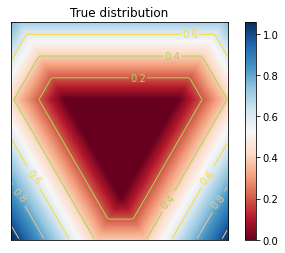

In [6]:
plt.figure()
plt.title('True distribution')
plot_network(true_dist_state)
plt.show()

In [7]:
def generate_data(num_samples):
  # The distribution q(x) is uniform on the unit square [-1,1]x[-1,1]
  x1_coords = 2 * np.random.rand(num_samples) - 1
  x2_coords = 2 * np.random.rand(num_samples) - 1

  X_data = []
  y_data = []

  for (x1,x2) in zip(x1_coords, x2_coords):
    X = np.array([[x1, x2]])
    true_labels_dist = true_network(X.astype("float32"))
    y = true_labels_dist.sample().numpy()
  
    X_data.append(np.array([x1,x2]))
    y_data.append(y)
  
  X_data = np.array(X_data)
  y_data = np.array(y_data)
  
  return (X_data, y_data)

training_sets_x = []
training_sets_y = []

for i in range(args.num_training_sets):
  X_train, y_train = generate_data(args.training_sample_size)
  training_sets_x.append(X_train)
  training_sets_y.append(y_train)

X_test, y_test = generate_data(args.training_sample_size)

#print(training_sets_x[0][:10])
#print(training_sets_y[0][:10])

center = true_dist_state

NUM_PARAMS = 0
for s in true_dist_state:
  print("State shape", s.shape)
  NUM_PARAMS += s.shape.num_elements()
print("Total params", NUM_PARAMS)

State shape (2, 10)
State shape (10,)
State shape (10, 1)
State shape (1,)
Total params 41


# 3. Hamiltonian Monte Carlo

We perform HMC on the weight vector for the model class $p(y|x,w)$ determined by $f(x,w)$ a feedforward ReLU network with $m$ nodes in the hidden layer, where $m$ is the symmetry factor.

### 3.1 Estimate the posterior around the true parameter

We generate, for each inverse temperature $\beta$ and dataset $D_n$, a Markov Chain via HMC starting from the true parameter $w_0$ (`center` in the code). The function `joint_log_prob_fn` computes the numerator of the posterior distribution at a given inverse temperature $\beta$. More specifically, assuming that the prior is a multivariate normal distribution centered at $w_0$ with diagonal covariance matrix $\Sigma$ with constant entries $\sigma^2$, the logarithm of this numerator is

$$
\begin{align*}
\log\big[p^\beta(D_n|w)\varphi(w)\big] &= - \beta n L_n(w) + \log\Big[ \frac{1}{\sigma \sqrt{(2\pi)^d}} \exp\big(-\frac{1}{2} \frac{ || w - w_0 ||^2 }{\sigma^2}\big) \Big] \\
&= \beta \sum_{i=1}^n \log p(y_i | x_i,w) - \frac{1}{2 \sigma^2} || w - w_0 ||^2 + C(\sigma, d)
\end{align*}
$$
where $C(\sigma,d) = - \log \sigma - \frac{d}{2} \log(2\pi)$. Note that the two contributions to the log probability are $p(y_i | x_i,w)$ and the weight regularisation $|| w - w_0 ||^2$ from the prior, and these occur with respective temperatures $1/\beta$ and $2 \sigma^2$. *A priori* the posterior will be more difficult to approximate (e.g. require more computational resources for generating Markov chains) **when $\beta$ increases** (the lower the temperature, the sharper the peaks and troughs in the density).

Note that $D_n$ is specified via `X,y` in the code, and we have the following dictionary between math and code:

$\sigma$ = `args.global_prior_bias_std`

$d$ = `NUM_PARAMS`

$w_0$ = `center`

In [8]:
# Setup priors
weight_prior = tfd.Normal(0.0, args.global_prior_weight_std)
bias_prior = tfd.Normal(0.0, args.global_prior_bias_std)

n = args.training_sample_size

betas = np.linspace(1 / np.log(n) * (1 - 1 / np.sqrt(2 * np.log(n))),
                                 1 / np.log(n) * (1 + 1 / np.sqrt(2 * np.log(n))), args.num_betas)
print("Betas:")
print(betas)

posteriors = []

# For each inverse temperature beta and each dataset we generate a posterior
# in which the prior is centered at the true distribution
for b in betas:
  posteriors_b = []
  
  for (X_train, y_train) in zip(training_sets_x,training_sets_y):
    logp = partial(joint_log_prob_fn, center, weight_prior, 
                 bias_prior, X_train, y_train, b)
    posteriors_b.append(logp)
    
  posteriors.append(posteriors_b)

Betas:
[0.10581733 0.11447233 0.12312733 0.13178233 0.14043733 0.14909233
 0.15774733 0.16640233 0.17505733 0.18371233]


In [9]:
# Run the chains. This will take a while...
mc_chains = []
min_ess = 10.0

i = 0
  
for (b,p_list) in zip(betas,posteriors):
  i += 1
  print("Beta [" + str(i) + "/" + str(args.num_betas) + "] " + str(b))

  mc_chains_b = []
  j = 0

  for logprob in p_list:
    j += 1
    print("       Dataset [" + str(j) + "/" + str(args.num_training_sets) + "]")

    # Attempt to load from disk
    filename = args.save_prefix + '/' + args.experiment_id + '-beta' + str(i) + '-dataset' + str(j) + '.pickle'
  
    if os.path.isfile(filename) and args.load_data:
      with open(filename, 'rb') as handle:
        fine_chain = pickle.load(handle)
        print("         Loaded chain from disk")
    else:
      pre_time = time.time()
      
      fine_chain, fine_trace, final_kernel_results = run_hmc(
        logprob,
        num_burnin_steps=args.mc_burnin_steps,
        num_leapfrog_steps=args.mc_leapfrog_steps,
        num_adaptation_steps=args.mc_adaptation_steps,
        num_results=args.mc_num_results,
        step_size=args.mc_step_size,
        current_state=center)
      
      post_time = time.time()
      delta_time = post_time - pre_time

      # Save this chain to disk
      with open(filename, 'wb') as handle:
        pickle.dump(fine_chain, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("         Saved chain to disk")
        
      print("         Time taken (s):", delta_time)
      print("         Acceptance rate:", fine_trace.inner_results.is_accepted[-args.mc_num_results:].numpy().mean())

      for c in fine_chain:
        ess_per_step = tf.reduce_min(tfp.mcmc.effective_sample_size(c[-args.mc_num_results:]) / args.mc_num_results).numpy()

        if( ess_per_step < min_ess ):
          min_ess = ess_per_step

        print("         ESS/step", ess_per_step)
      
    mc_chains_b.append(fine_chain)

  mc_chains.append(mc_chains_b)

Beta [1/10] 0.10581732720669002
       Dataset [1/3]
Loaded chain from disk
       Dataset [2/3]
Loaded chain from disk
       Dataset [3/3]
Loaded chain from disk
Beta [2/10] 0.11447232722766644
       Dataset [1/3]
Loaded chain from disk
       Dataset [2/3]
Loaded chain from disk
       Dataset [3/3]
Loaded chain from disk
Beta [3/10] 0.12312732724864288
       Dataset [1/3]
Loaded chain from disk
       Dataset [2/3]
Loaded chain from disk
       Dataset [3/3]
Loaded chain from disk
Beta [4/10] 0.1317823272696193
       Dataset [1/3]
Loaded chain from disk
       Dataset [2/3]
Loaded chain from disk
       Dataset [3/3]
Loaded chain from disk
Beta [5/10] 0.14043732729059574
       Dataset [1/3]
Loaded chain from disk
       Dataset [2/3]
Loaded chain from disk
       Dataset [3/3]
Loaded chain from disk
Beta [6/10] 0.14909232731157218
       Dataset [1/3]
Loaded chain from disk
       Dataset [2/3]
Loaded chain from disk
       Dataset [3/3]
Loaded chain from disk
Beta [7/10] 0.157

         Saved chain to disk
         Time taken (s): 1828.136697769165
         Acceptance rate: 0.57018
         ESS/step 0.020791158
         ESS/step 0.020234847
         ESS/step 0.021542279
         ESS/step 0.03810546


### 3.2 Analyse the results

HMC has various hyperparameters: the number of burnin steps, the amount of time to adapt the step size, the number of leapfrog steps, and the amount of thinning we do on the resulting chain to try and generate uncorrelated samples. The "health" of the chains we are generating has to be carefully monitored:

"Tuning HMC will usually require preliminary runs with trial values... trace plots of quantities that are thought to be indicative of overall convergence should be examined... the value of the potential energy function U(q) is also usually of central importance. The autocorrelation for such quantities indicates how well the Markov chain is exploring the state space. Ideally, we would like the state after one HMC iteration to be nearly independent of the previous state." -- R. M. Neal "MCMC using Hamiltonian mechanics", Section 5.4.2

In our case the potential energy is (see Section B Nagata-Watanabe "Exchange Monte Carlo sampling from Bayesian posterior for singular learning machines") the negative log probability $-\log p^\beta(w|D_n)$. We also monitor the angle between $v_{i} - w_0$ and $v_0 - w_0$ where $v_0$ is the first weight in the chain and $w_0$ is the weight vector of the true distribution.

These graphs are all for the first dataset.

In [10]:
short_chain_length = 500

DISPLAY_ENERGY = False

if( DISPLAY_ENERGY ):
  i = 0

  print("")

  for (b,fc) in zip(betas,mc_chains):
    i += 1
    print("[" + str(i) + "/" + str(args.num_betas) + "] Graphs for inverse temperature " + str(b))

    short_chain = []

    for c in fc[0]:
      short_chain.append(c[-short_chain_length:])

    plt.figure()
    plt.title("Potential energy")
    plot_curves(short_chain)
    plt.show()

Note that in a high-dimensional multivariate Gaussian, the expected value of the norm of a sample is `sigma \sqrt{d}` where `sigma` is the standard deviation and `d` is the dimension. So our first sanity check is to see whether the mean of norms of the samples in our Markov Chain line up with the expected norm that we would expect from sampling from the new localised prior.

Mean sample norm from global prior Gaussian: 0.32015621187164245

[1/10] Graphs for inverse temperature 0.10581732720669002
Mean of distances: 0.9632807


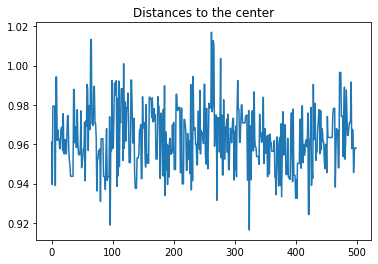

[2/10] Graphs for inverse temperature 0.11447232722766644
Mean of distances: 0.9668662


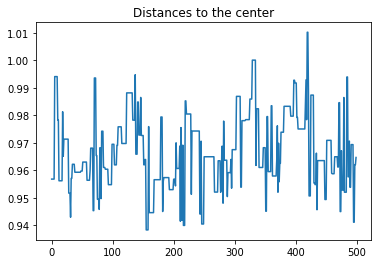

[3/10] Graphs for inverse temperature 0.12312732724864288
Mean of distances: 0.9725647


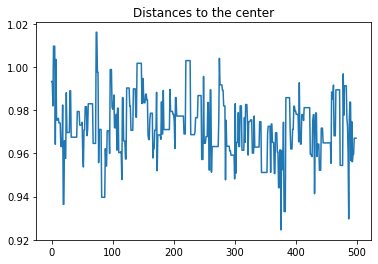

[4/10] Graphs for inverse temperature 0.1317823272696193
Mean of distances: 0.9760466


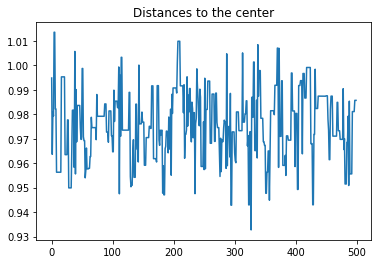

[5/10] Graphs for inverse temperature 0.14043732729059574
Mean of distances: 0.9765654


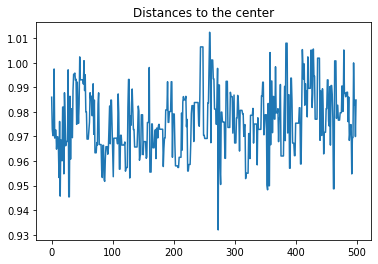

[6/10] Graphs for inverse temperature 0.14909232731157218
Mean of distances: 0.97775245


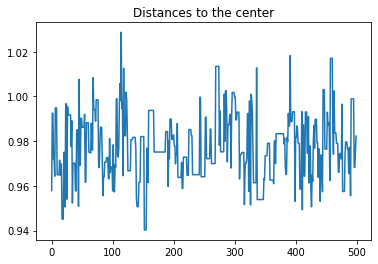

[7/10] Graphs for inverse temperature 0.1577473273325486
Mean of distances: 1.0159307


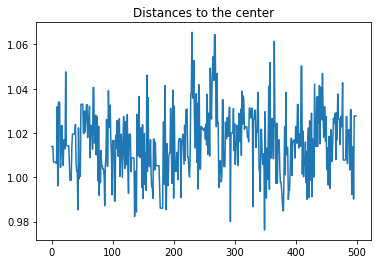

[8/10] Graphs for inverse temperature 0.16640232735352503
Mean of distances: 1.0170075


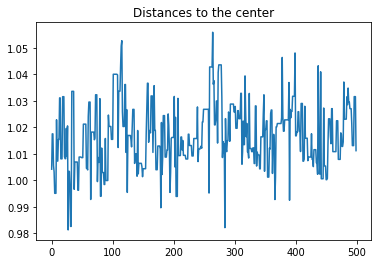

[9/10] Graphs for inverse temperature 0.17505732737450147
Mean of distances: 1.0169761


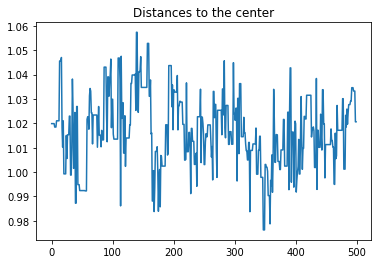

[10/10] Graphs for inverse temperature 0.18371232739547788
Mean of distances: 1.0199932


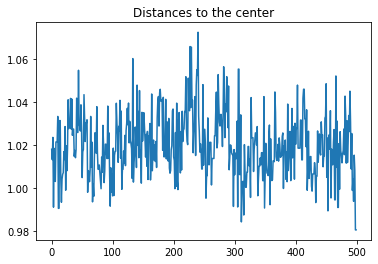

In [11]:
print("Mean sample norm from global prior Gaussian: " + str(args.global_prior_weight_std * np.sqrt(NUM_PARAMS)))

i = 0

print("")

for (b,fc) in zip(betas,mc_chains):
  i += 1
  print("[" + str(i) + "/" + str(args.num_betas) + "] Graphs for inverse temperature " + str(b))

  short_chain = []

  for c in fc[0]:
    short_chain.append(c[-short_chain_length:])
    
  plt.figure()
  plt.title("Distances to the center")
  plot_distances(short_chain, center)
  plt.show()

We let `short_chain` be a small segment from the overall chain, and plot the angles that various components of the weight and bias vector make with their values at the beginning of `short_chain`. The cosines of angles between the full vectors are graphed as `concat`. We can see that initially the cosine of the angle is `1`, as expected, and then decreases to `0`. Note that in high dimensions two generic vectors are orthogonal, so this is expected. Some components do reach the other side of the `d`-sphere though, see for example `biases 3`.

These graphs, together with the above discussion of distances, support the hypothesis that the posterior around `center` with the localised prior, is spherical at the expected distance and not concentrated in just a small neighborhood of a point on that sphere.

--------------------------------
Inverse temperature beta 0.10581732720669002


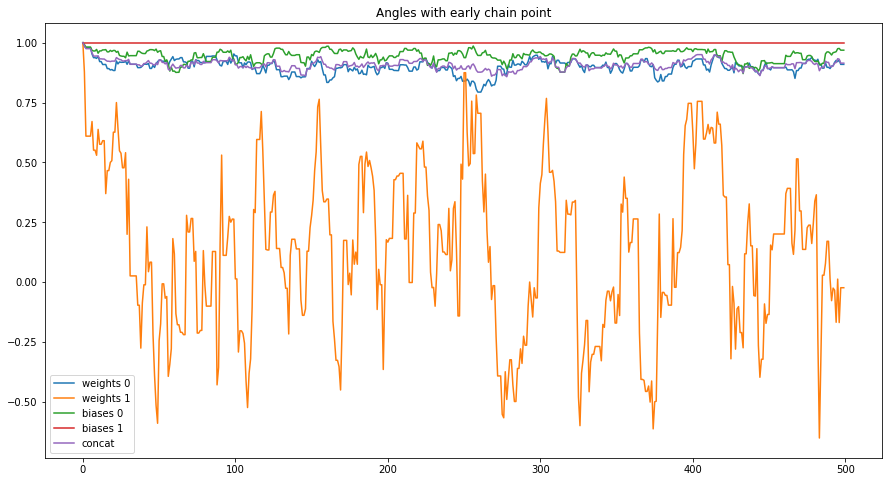

--------------------------------
Inverse temperature beta 0.11447232722766644


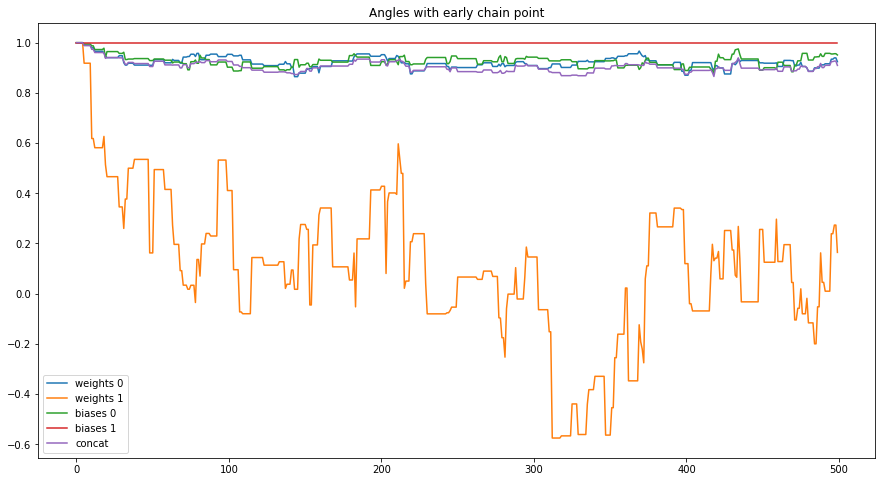

--------------------------------
Inverse temperature beta 0.12312732724864288


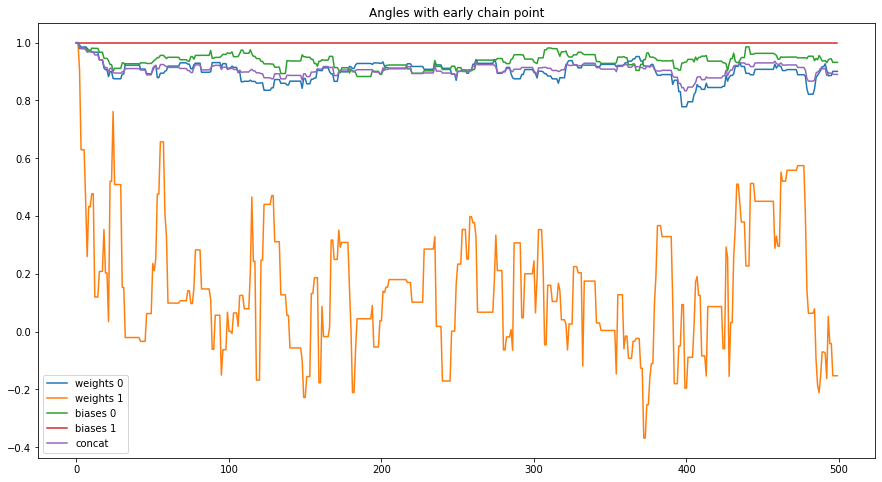

--------------------------------
Inverse temperature beta 0.1317823272696193


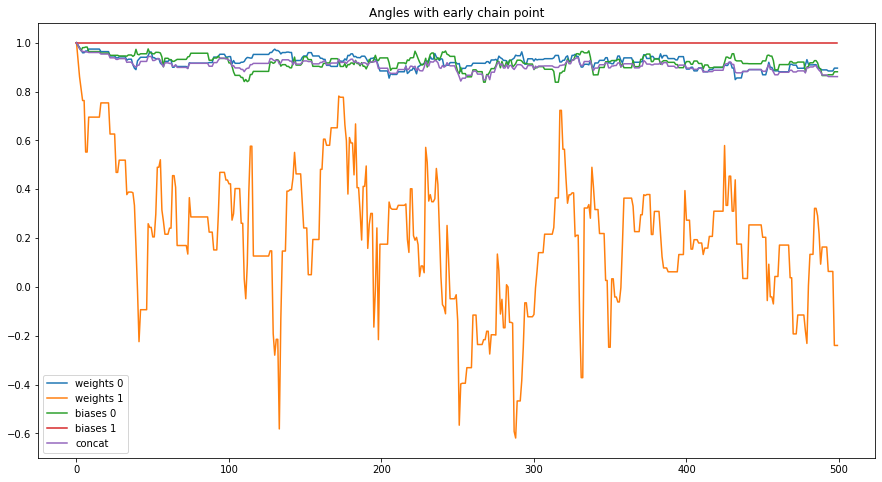

--------------------------------
Inverse temperature beta 0.14043732729059574


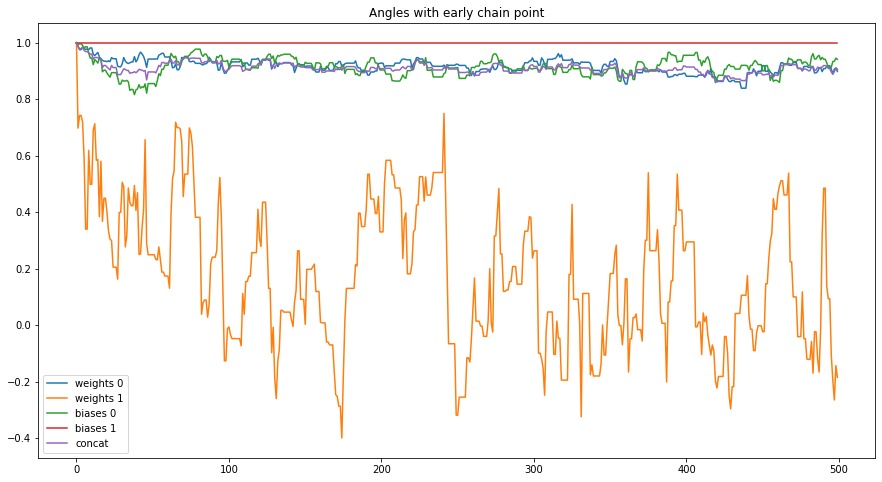

--------------------------------
Inverse temperature beta 0.14909232731157218


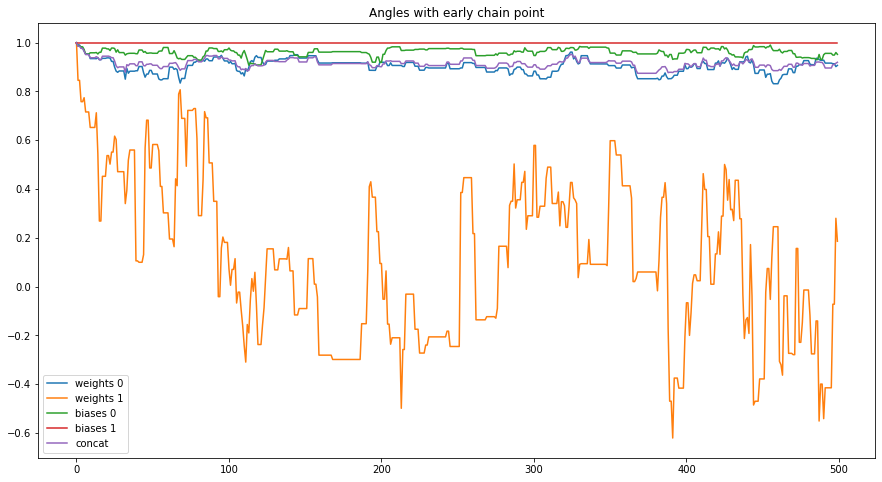

--------------------------------
Inverse temperature beta 0.1577473273325486


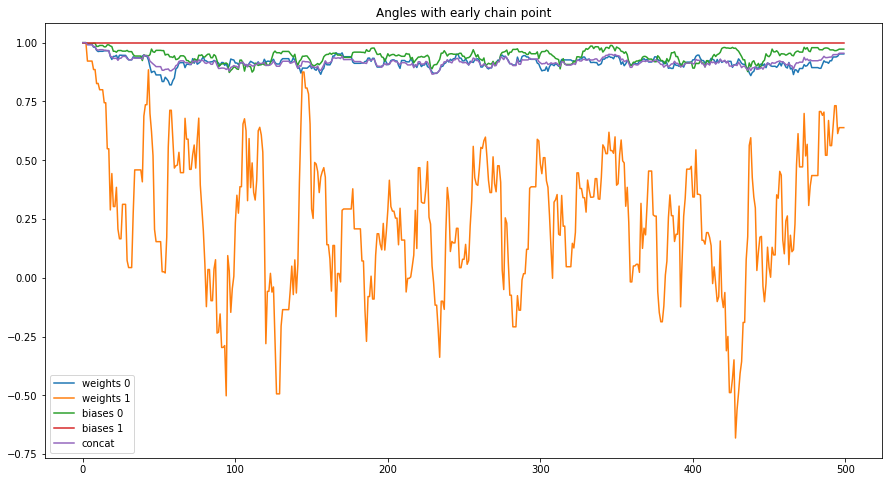

--------------------------------
Inverse temperature beta 0.16640232735352503


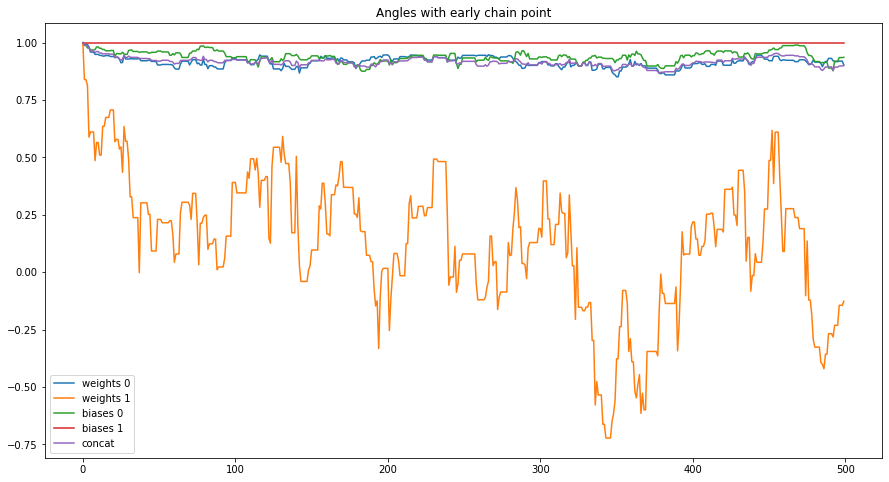

--------------------------------
Inverse temperature beta 0.17505732737450147


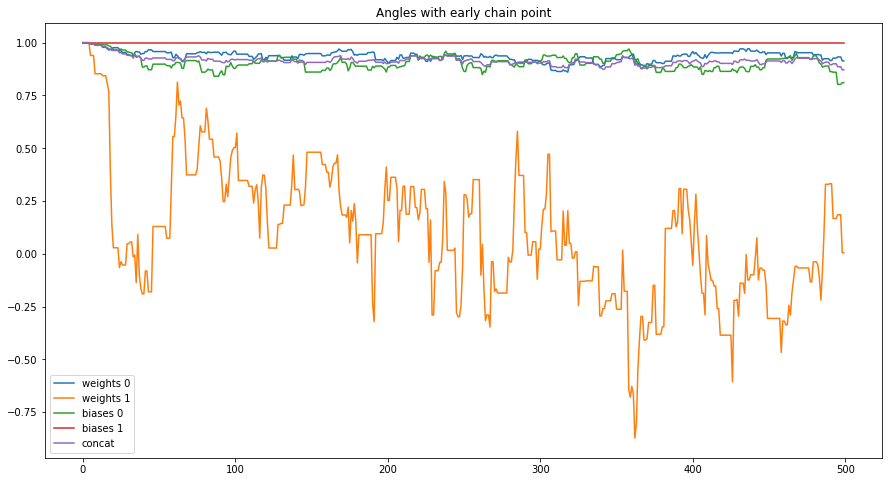

--------------------------------
Inverse temperature beta 0.18371232739547788


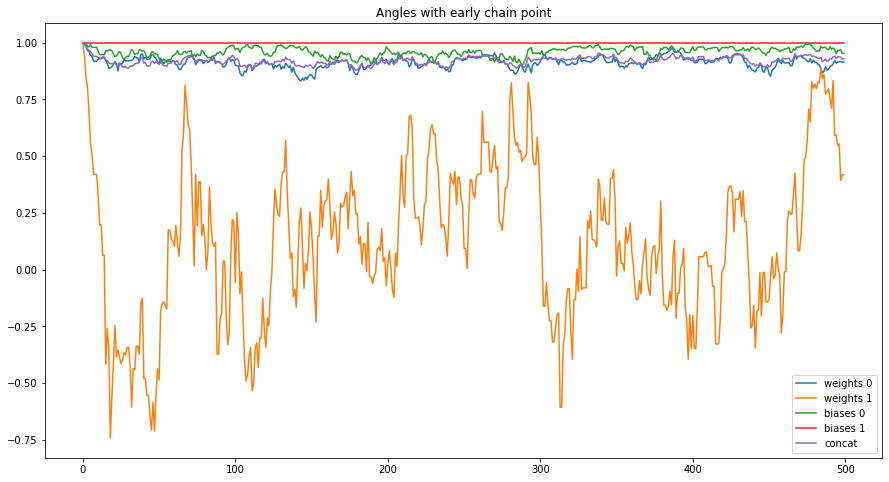

In [12]:
# Note that the dot product of high dimensional vectors is generically zero, as the orthogonal subspace
# is dim(V)-1. We graph the cos(angle) between the first point in the short_chain and the following chain steps,
# between the various weight and bias vectors, and the full weight/bias vector (concat)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

# These visualiations are all for the first dataset
for (b,fc) in zip(betas,mc_chains):
  print("--------------------------------")
  print("Inverse temperature beta " + str(b))
  
  short_chain = []

  for c in fc[0]:
    short_chain.append(c[-short_chain_length:])
  
  plt.figure()
  plt.title("Angles with early chain point")
  plot_angles(short_chain, center)
  plt.show()

--------------------------------
Inverse temperature beta 0.18371232739547788


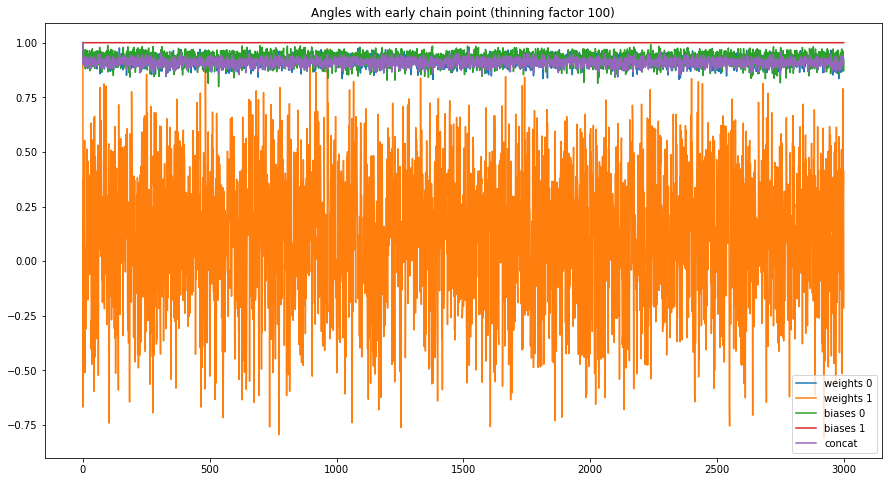

In [13]:
thin_factor = 100

b = betas[-1]
fc = mc_chains[-1]

print("--------------------------------")
print("Inverse temperature beta " + str(b))

short_chain = []

for c in fc[0]:
  short_chain.append(c[-args.mc_num_results::thin_factor])

plt.figure()
plt.title("Angles with early chain point (thinning factor " + str(int(thin_factor)) + ")")
plot_angles(short_chain, center)
plt.show()

In [14]:
#plt.figure()
#plt.title("Norm of weight vector")
#plot_distances(short_chain, [0.0*x for x in center])
#plt.show()

How far does the chain tend to travel in `200` steps? Note that on a sphere of radius `0.0001154469` any two orthogonal points will be at a distance of `0.00016326` so given the relaxation time visible in the angle graph, it would be surprising if we do not see a mean around this.

In [15]:
#plt.figure()
#plt.title("Offset distances of chain weights")
#plot_distances_offset(short_chain, 200)
#plt.show()

### 3.3 Estimating the RLCT

Recall that the log likelihood of a weight vector, with respect to the training data and the original global prior used for training, is `joint_log_prob`.

[1/10] Estimates for inverse temperature beta 0.10581732720669002
    E_w[nL_n(w)] over datasets: [1453579.6, 1453612.2, 1453727.2]
    E_{D_n}E_w[nL_n(w)]: 1453639.6
    Std_{D_n}E_w[nL_n(w)]: 63.31806

[2/10] Estimates for inverse temperature beta 0.11447232722766644
    E_w[nL_n(w)] over datasets: [1453563.6, 1453592.5, 1453714.8]
    E_{D_n}E_w[nL_n(w)]: 1453623.6
    Std_{D_n}E_w[nL_n(w)]: 65.50453

[3/10] Estimates for inverse temperature beta 0.12312732724864288
    E_w[nL_n(w)] over datasets: [1453550.5, 1453576.6, 1453703.4]
    E_{D_n}E_w[nL_n(w)]: 1453610.1
    Std_{D_n}E_w[nL_n(w)]: 66.76564

[4/10] Estimates for inverse temperature beta 0.1317823272696193
    E_w[nL_n(w)] over datasets: [1453538.6, 1453562.9, 1453694.0]
    E_{D_n}E_w[nL_n(w)]: 1453598.5
    Std_{D_n}E_w[nL_n(w)]: 68.250534

[5/10] Estimates for inverse temperature beta 0.14043732729059574
    E_w[nL_n(w)] over datasets: [1453528.9, 1453550.9, 1453686.1]
    E_{D_n}E_w[nL_n(w)]: 1453588.6
    Std_{D_n}E_w[

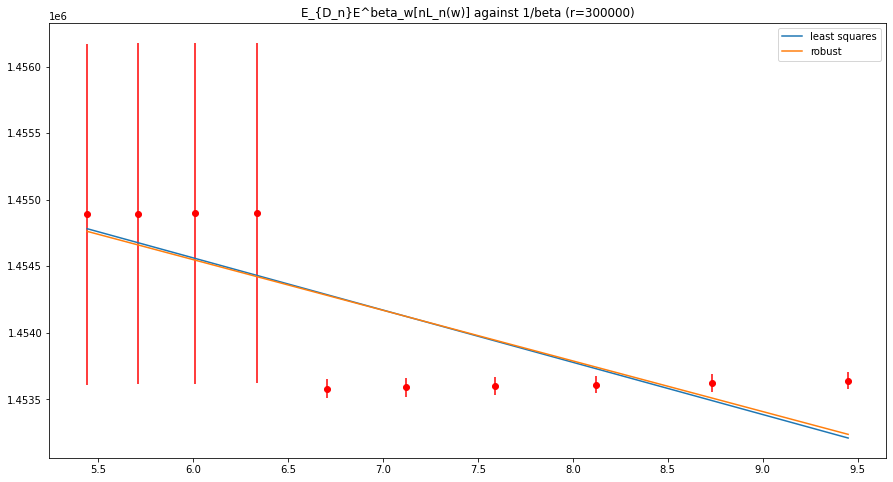

In [16]:
#args.mc_thin_factor = 1

if( min_ess * args.mc_num_results < 100 ):
  print("---- WARNING ----")
  print("")
  print("   It is likely your chain is not long enough to get even 100 reasonably")
  print("   independent samples, your results are probably garbage.")
  print("")
  print("---- WARNING ----")
  print("")
  
log_prob_noprior = partial(
    joint_log_prob_fn, center, None, None, X_train, y_train, 1.0
)

estimates = []
estimates_err = []

z = 0

for (b,fc_list) in zip(betas,mc_chains):
  z += 1
  print("[" + str(z) + "/" + str(args.num_betas) + "] Estimates for inverse temperature beta " + str(b))
  
  EnLn_estimates = []
  
  # For each inverse temperature we have a set of datasets sampled from
  # the true distribution, all of size n
  for fc in fc_list:
    rlct_chain = []

    # c is a list, one entry per weight or bias vector, and each of those
    # entries is itself a list indexed by the position in the chain
    for c in fc:
      c = c[-args.mc_num_results::args.mc_thin_factor] # throw out the burnin steps and thin
      rlct_chain.append(c)

    # nL_n(w) = - log_prob_noprior(*w)
    n_Ln_samples = []

    for i in range(len(c)):
      w = [q[i] for q in rlct_chain]
      n_Ln_samples.append(-log_prob_noprior(*w))
  
    EnLn_estimates.append(np.mean(n_Ln_samples))
    
  print("    E_w[nL_n(w)] over datasets: " + str(EnLn_estimates))
  print("    E_{D_n}E_w[nL_n(w)]: " + str(np.mean(EnLn_estimates)))
  print("    Std_{D_n}E_w[nL_n(w)]: " + str(np.std(EnLn_estimates)))
  print("")
  
  estimates.append(np.mean(EnLn_estimates))
  estimates_err.append(np.std(EnLn_estimates))
  
# Note that if
#
# p(y|x,w) = 1/(2 \pi)^{d/2} exp(-1/2|| y - f(x,w) ||^2)
# 
# then
#
# nL_n(w) = -\sum_{i=1}^n log p(y_i|x_i,w)
#         = -\sum_{i=1}^n log[ 1/(2 \pi)^{d/2} exp(-1/2|| y_i - f(x_i,w) ||^2) ]
#         = -\sum_{i=1}^n[ -(d/2)log(2\pi) - 1/2|| y_i - f(x_i,w) ||^2 ]
#         = (nd/2) * log(2\pi) + \sum_{i=1}^n 1/2|| y_i - f(x_i,w) ||^2 
#
# Note that if n = 1000 and d = 52 then the first summand is ~59525.

print("")

from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

if( len(mc_chains) > 1 ):
  plt.figure()
  r = int(args.mc_num_results/args.mc_thin_factor)
  plt.title("E_{D_n}E^beta_w[nL_n(w)] against 1/beta (r=" + str(r) + ")")
  plt.errorbar(x=1/betas, y=estimates, yerr=estimates_err,fmt='ro')
  
  m, b = np.polyfit([1/b for b in betas], estimates, 1)
  print("n   = " + str(args.training_sample_size))
  print("r   = " + str(r))
  print("D/2 = " + str(NUM_PARAMS/2))
  print("min_ess = " + str(min_ess))
  print("mc_thin_factor = " + str(args.mc_thin_factor))

  plt.plot(1/betas, [m*x + b for x in 1/betas], label='least squares')
  
  # robust ls fit
  regr = ElasticNet(random_state=0, fit_intercept=True, alpha=0.1)
  regr.fit((1 / betas).reshape(args.num_betas, 1), estimates)
  b_robust = regr.intercept_
  m_robust = regr.coef_[0]
  
  #print("OLS estimate of RLCT    = " + str(m))
  print("\nRobust estimate of RLCT = " + str(m_robust))
  
  plt.plot(1/betas, [m_robust * x + b_robust for x in 1/betas], label='robust')
  
  plt.legend(loc='best')
  
  plt.show()


Robust estimate of RLCT = -380.6405818110013


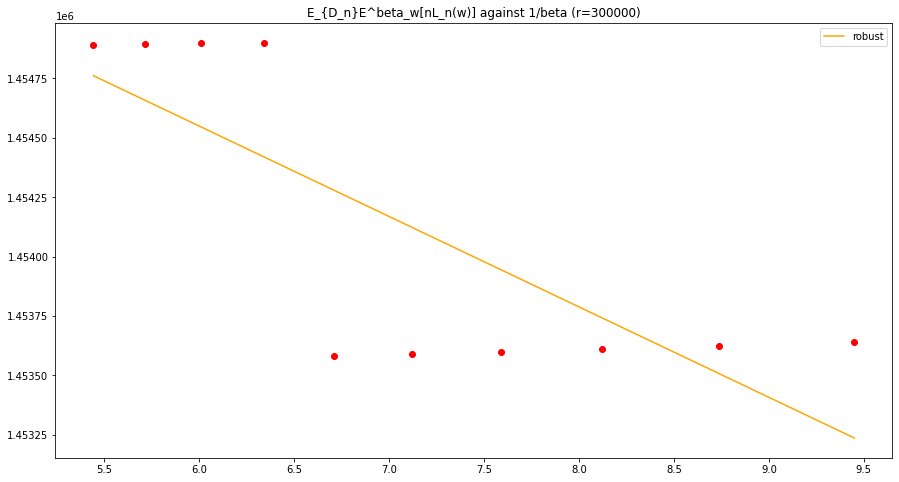

In [31]:
#### Same as above, but with a closer crop of the datapoints

if( len(mc_chains) > 1 ):
  plt.figure()
  plt.title("E_{D_n}E^beta_w[nL_n(w)] against 1/beta (r=" + str(r) + ")")
  plt.errorbar(x=1/betas, y=estimates, fmt='ro')
  
  #m, b = np.polyfit([1/b for b in betas], estimates, 1)
  
  #plt.plot(1/betas, [m*x + b for x in 1/betas], label='least squares')
  
  # robust ls fit
  sub_betas = betas
  sub_estimates = estimates
  
  regr = ElasticNet(random_state=0, fit_intercept=True, alpha=0.1)
  regr.fit((1 / sub_betas).reshape(len(sub_betas), 1), sub_estimates)
  b_robust = regr.intercept_
  m_robust = regr.coef_[0]
  print("\nRobust estimate of RLCT = " + str(m_robust))
  
  plt.plot(1/betas, [m_robust * x + b_robust for x in 1/betas], label='robust', color='orange')

  plt.legend(loc='best')
  
  plt.show()


Second robust estimate of RLCT = 20.522723860851148

First robust estimate of RLCT = 7.73898408696984


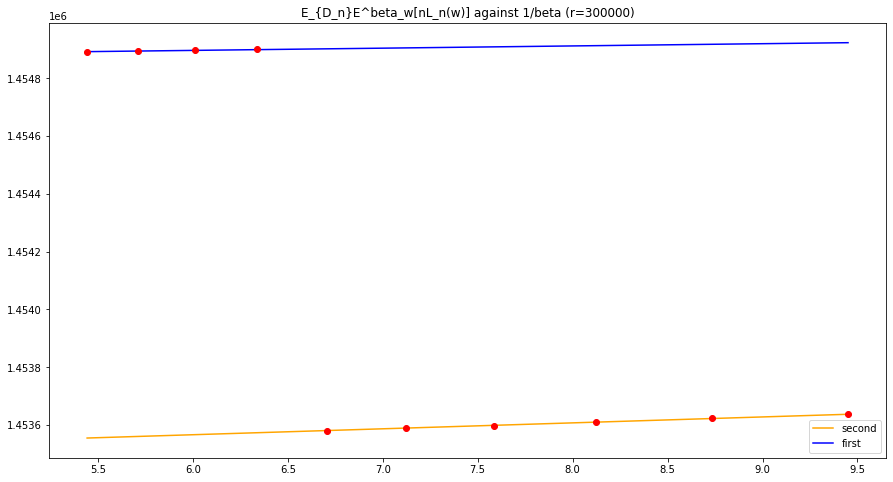

In [44]:
#### Modified for multiple components

if( len(mc_chains) > 1 ):
  plt.figure()
  plt.title("E_{D_n}E^beta_w[nL_n(w)] against 1/beta (r=" + str(r) + ")")
  plt.errorbar(x=1/betas, y=estimates, fmt='ro')
  
  # robust ls fit
  sub_betas = betas[:6]
  sub_estimates = estimates[:6]
  
  regr = ElasticNet(random_state=0, fit_intercept=True, alpha=0.1)
  regr.fit((1 / sub_betas).reshape(len(sub_betas), 1), sub_estimates)
  b_robust = regr.intercept_
  m_robust = regr.coef_[0]
  print("\nSecond robust estimate of RLCT = " + str(m_robust))
  
  plt.plot(1/betas, [m_robust * x + b_robust for x in 1/betas], label='second', color='orange')
  
  # robust ls fit
  sub_betas = betas[6:]
  sub_estimates = estimates[6:]
  
  regr = ElasticNet(random_state=0, fit_intercept=True, alpha=0.1)
  regr.fit((1 / sub_betas).reshape(len(sub_betas), 1), sub_estimates)
  b_robust = regr.intercept_
  m_robust = regr.coef_[0]
  print("\nFirst robust estimate of RLCT = " + str(m_robust))
  
  plt.plot(1/betas, [m_robust * x + b_robust for x in 1/betas], label='first', color='blue')

  plt.legend(loc='best')
  
  plt.show()

In [39]:
l = [1,2,3,4,5,6,7]
print(l[4:])

[5, 6, 7]


In [40]:
1/betas

array([9.45024814, 8.73573574, 8.1216739 , 7.58827091, 7.12061401,
       6.70725327, 6.33925162, 6.00953133, 5.71241441, 5.44329286])